In [60]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

Skidanje cijena pomoću yfinance paketa:

In [61]:
tickers = ["SPY", "AGG", "GC=F", "VNQ"]

prices = yf.download(tickers, start="2012-01-01", end="2023-12-31")["Adj Close"]

prices

[*********************100%***********************]  4 of 4 completed


Ticker,AGG,GC=F,SPY,VNQ
Date,,,,
2012-01-03 00:00:00+00:00,79.201958,1599.699951,101.091980,35.285404
2012-01-04 00:00:00+00:00,79.093948,1611.900024,101.250519,34.682133
2012-01-05 00:00:00+00:00,79.201958,1619.400024,101.520119,35.007900
2012-01-06 00:00:00+00:00,79.266708,1616.099976,101.258438,34.893280
2012-01-09 00:00:00+00:00,79.201958,1607.500000,101.504227,34.772621
...,...,...,...,...
2023-12-22 00:00:00+00:00,95.852516,2057.100098,469.225250,85.181526
2023-12-26 00:00:00+00:00,96.046486,2058.199951,471.206573,85.812790
2023-12-27 00:00:00+00:00,96.657509,2081.899902,472.058563,86.230400


Čitanje i parsiranje csv dokumenta koji sadrži težine svake klase imovine, ispis težina klasa po godinama

In [62]:
csvfile = pd.read_csv("asset_class_marketcaps.csv", skiprows=1)
marketcap_years = [str(year) for year in range(2012, 2024)]
weights_years = [str(year) + ".1" for year in range(2012, 2024)]

marketcap_df = csvfile[["Asset class"] + marketcap_years]

weights_df = csvfile[["Asset class"] + weights_years]
weights_df.columns = ["Asset class"] + marketcap_years

weights_df = weights_df.set_index("Asset class")

weights_df = weights_df.apply(lambda x: x.str.rstrip("%").astype(float) / 100)

weights_df.style.format("{:,.2%}")

,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Asset class,,,,,,,,,,,,
Equity,35.06%,40.81%,40.62%,40.64%,40.67%,42.67%,40.41%,42.43%,42.44%,46.09%,45.04%,46.72%
Fixed income,48.21%,46.00%,46.19%,46.63%,46.53%,44.80%,46.90%,44.99%,45.52%,42.45%,42.95%,41.62%
Commodity,12.27%,8.30%,7.74%,7.10%,7.33%,7.15%,7.29%,7.33%,7.93%,6.92%,8.04%,7.93%
Real estate,4.47%,4.89%,5.46%,5.63%,5.46%,5.38%,5.41%,5.25%,4.12%,4.54%,3.97%,3.73%


Pretvaranje cijena tickera u postotne povrate (razlika u cijeni iz dana u dan)

In [63]:
change = prices.pct_change(1, fill_method=None).dropna()
change

Ticker,AGG,GC=F,SPY,VNQ
Date,,,,
2012-01-04 00:00:00+00:00,-0.001364,0.007626,0.001568,-0.017097
2012-01-05 00:00:00+00:00,0.001366,0.004653,0.002663,0.009393
2012-01-06 00:00:00+00:00,0.000818,-0.002038,-0.002578,-0.003274
2012-01-09 00:00:00+00:00,-0.000817,-0.005321,0.002427,-0.003458
2012-01-10 00:00:00+00:00,-0.000273,0.014619,0.008671,0.011103
...,...,...,...,...
2023-12-22 00:00:00+00:00,-0.001314,0.008827,0.002010,0.003892
2023-12-26 00:00:00+00:00,0.002024,0.000535,0.004223,0.007411
2023-12-27 00:00:00+00:00,0.006362,0.011515,0.001808,0.004867


Pretvaranje dnevnih povrata u godišnje povrate radi konteksta

In [64]:
yearly_change = change.groupby(change.index.year).apply(lambda x: (1 + x).prod() - 1)
yearly_change.index.name = "Year"

yearly_change.style.format("{:,.2%}")

Ticker,AGG,GC=F,SPY,VNQ
Year,,,,
2012,3.96%,4.69%,14.17%,16.65%
2013,-1.98%,-28.24%,32.31%,2.30%
2014,6.00%,-1.50%,13.46%,30.40%
2015,0.48%,-10.44%,1.23%,2.43%
2016,3.22%,12.03%,13.01%,5.80%
2017,3.55%,13.59%,21.71%,4.90%
2018,0.68%,-0.96%,-2.94%,-4.05%
2019,8.46%,18.87%,31.22%,28.91%
2020,7.48%,24.59%,18.33%,-4.61%


Računanje težinskih godišnjih povrata svakog tickera u indeksu (koliko je koja klasa pridonjelja godišnjem povratu indeksa)

In [65]:
asset_class_to_ticker_map = {
    "Equity": "SPY",
    "Fixed income": "AGG",
    "Commodity": "GC=F",
    "Real estate": "VNQ",
}

weights_df_copy = weights_df.copy()

weights_df_copy.rename(index=asset_class_to_ticker_map, inplace=True)
weights_df_copy = weights_df_copy.transpose()
weights_df_copy.index = weights_df_copy.index.astype("int64")

weighted_returns = weights_df_copy.multiply(yearly_change)

weighted_returns.style.format("{:,.2%}")

,AGG,GC=F,SPY,VNQ
2012,1.91%,0.58%,4.97%,0.74%
2013,-0.91%,-2.34%,13.18%,0.11%
2014,2.77%,-0.12%,5.47%,1.66%
2015,0.22%,-0.74%,0.50%,0.14%
2016,1.50%,0.88%,5.29%,0.32%
2017,1.59%,0.97%,9.26%,0.26%
2018,0.32%,-0.07%,-1.19%,-0.22%
2019,3.80%,1.38%,13.25%,1.52%
2020,3.40%,1.95%,7.78%,-0.19%
2021,-0.75%,-0.24%,13.24%,1.84%


Godišnji povrati indeksa dobiveni sumiranjem stupaca

In [66]:
index_returns = weighted_returns.sum(axis=1).to_frame()

index_returns.index.name = "Year"
index_returns.columns = ["Index Returns"]

index_returns.style.format("{:,.2%}")

,Index Returns
Year,
2012,8.20%
2013,10.04%
2014,9.78%
2015,0.12%
2016,7.99%
2017,12.09%
2018,-1.16%
2019,19.95%
2020,12.94%


Računamo betu svakog tickera prema formuli:

$$
\beta = \frac{\mathrm{Cov}(R_{\mathrm{stock}}, R_{\mathrm{market}})}{\mathrm{Var}(R_{\mathrm{market}})}
$$

gdje su:

- $R_{stock}$: Povrat dionice
- $R_{market}$: Povrat indeksa koji smo stvorili
- $\mathrm{Cov}(R_{stock}, R_{market})$: Kovarijanca između povrata dionice i povrata indeksa
- $\mathrm{Var}(R_{market})$: Varijanca povrata indeksa

In [67]:
daily_weights_df = change.index.to_frame()

# Pretpostavka da su weightovi svaki dan isti unutar jedne godine
daily_weights_df["Year"] = daily_weights_df["Date"].dt.year
daily_weights_df = daily_weights_df.merge(weights_df_copy, left_on="Year", right_index=True).set_index("Date")

daily_weights_df = daily_weights_df.drop(columns="Year")

daily_index_change = change.multiply(daily_weights_df).sum(axis=1)

In [68]:
kenneth_french_df = pd.read_csv("F-F_Research_Data_Factors_daily.CSV", skiprows=4)
kenneth_french_df = kenneth_french_df[:-3]

kenneth_french_df["Date"] = pd.to_datetime(kenneth_french_df["Date"], format="%Y%m%d")
kenneth_french_df = kenneth_french_df.set_index("Date")

kenneth_french_df

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-01,0.10,-0.25,-0.27,0.009
1926-07-02,0.45,-0.33,-0.06,0.009
1926-07-06,0.17,0.30,-0.39,0.009
1926-07-07,0.09,-0.58,0.02,0.009
1926-07-08,0.21,-0.38,0.19,0.009
...,...,...,...,...
2024-09-20,-0.27,-0.72,-0.64,0.020
2024-09-23,0.21,-0.85,-0.08,0.020
2024-09-24,0.24,0.12,-0.58,0.020


In [69]:
change.index = change.index.tz_localize(None)
daily_index_change.index = daily_index_change.index.tz_localize(None)

start_date = change.index[0]
end_date = change.index[-1]

filtered_kenneth_french_df = kenneth_french_df.loc[start_date:end_date]["RF"][1:] / 100
filtered_kenneth_french_df = filtered_kenneth_french_df.reindex(change.index, fill_value=0)

In [70]:
excess_index = daily_index_change.add(-filtered_kenneth_french_df, axis="index")
excess_change = change.add(-filtered_kenneth_french_df, axis="index")

In [71]:
def linear_regression(stock_returns=excess_change, index_returns=excess_index):
    """
    Implement linear regression for CAPM from scratch using ordinary least squares (OLS).
    
    """

    result = pd.DataFrame(columns=["Ticker", "Alpha", "Beta", "R_squared"])

    n = len(excess_change)

    x_mean = excess_index.mean()
    
    for stock in stock_returns.columns:
        selected_stock = stock_returns[stock]
        y_mean = selected_stock.mean()
        
        xy_sum = sum((index_returns - x_mean) * (selected_stock - y_mean))

        x_square_sum = sum((index_returns - x_mean)**2)

        beta = xy_sum / x_square_sum
        alpha = y_mean - beta * x_mean

        # R-squared
        y_pred = alpha + beta * index_returns
        ss_res = selected_stock.sub(y_pred).pow(2).sum() # residual sum of squares
        ss_tot = selected_stock.sub(y_mean).pow(2).sum()  # total sum of squares
        r_squared = 1 - (ss_res / ss_tot)

        row = pd.DataFrame({
            "Ticker": [stock],
            "Alpha": [alpha],
            "Beta": [beta],
            "R_squared": [r_squared]
        })
        result = pd.concat([result, row], ignore_index=True)

    result.set_index("Ticker", inplace=True)

    return result

result = linear_regression()
result

,Alpha,Beta,R_squared
Ticker,,,
AGG,-0.000022,0.210798,0.137067
GC=F,-0.000017,0.467242,0.065283
SPY,0.000041,1.843457,0.871429
VNQ,-0.000167,1.855787,0.642026


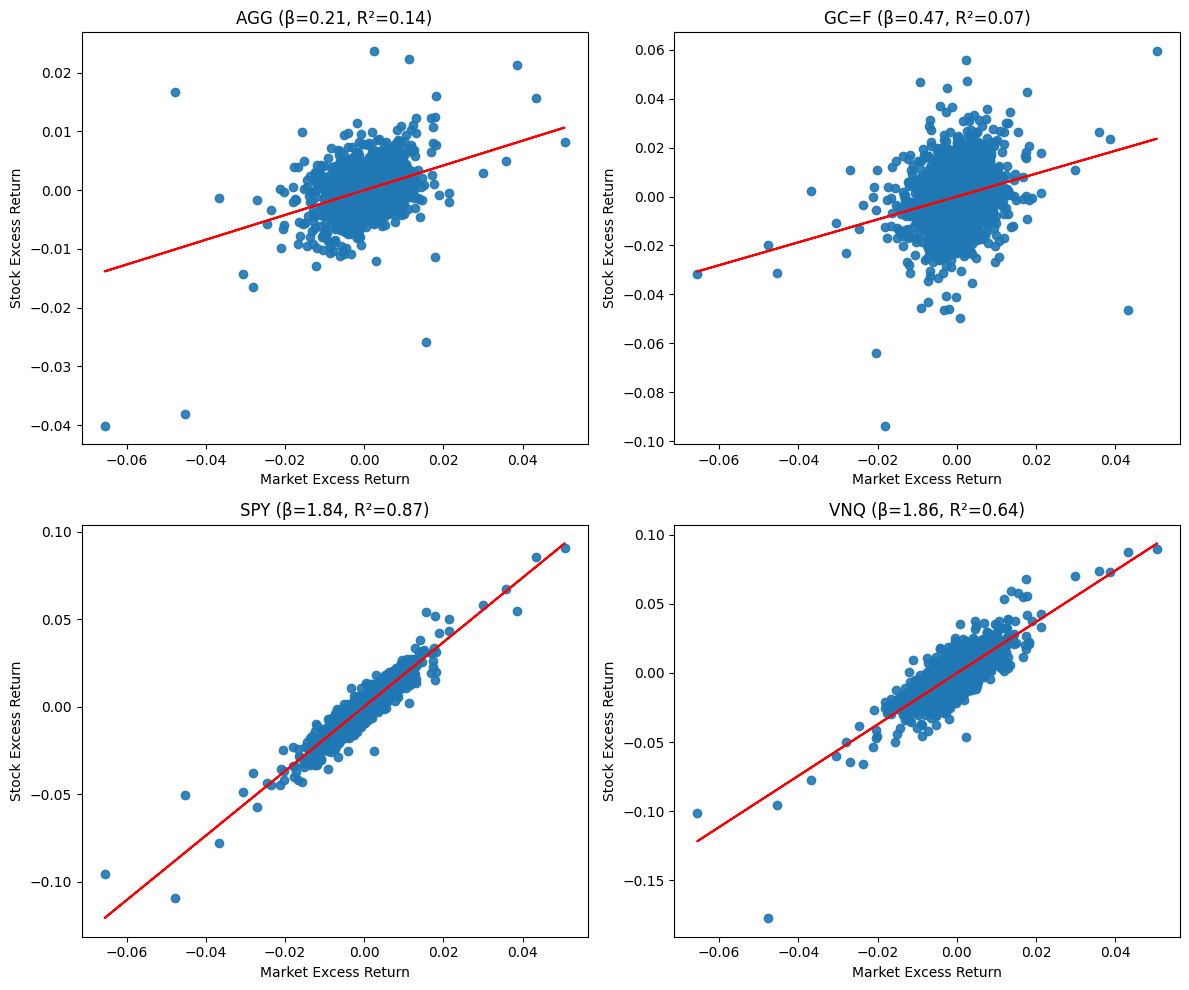

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, stock in enumerate(excess_change.columns):

    y = excess_change[stock]  

    beta = result.loc[stock, "Beta"]
    alpha = result.loc[stock, "Alpha"]
    
    axes[idx].scatter(excess_index, y, alpha=0.9)
    y_pred = alpha + beta * excess_index
    axes[idx].plot(excess_index, y_pred, 'r-')
    
    axes[idx].set_title(f'{stock} (β={beta:.2f}, R²={result.loc[stock, "R_squared"]:.2f})')
    axes[idx].set_xlabel('Market Excess Return')
    axes[idx].set_ylabel('Stock Excess Return')

plt.tight_layout()
plt.show()

In [73]:
start_year = excess_change.index[0].year
end_year = excess_change.index[-1].year + 1

yearly_excess_returns = excess_change.groupby(excess_change.index.year).apply(lambda x: (1 + x).prod() - 1)
yearly_excess_returns.index.name = "Year"

In [74]:
def switch(window, lam_param):

    comparison = pd.DataFrame(columns=["Period", "Ticker", "Predicted", "Real", "Window", "Lambda Type"])

    for period in range(start_year, end_year, window):
        start_date = f"{period}-01-01"
        end_date = f"{period + window}-01-01"
        
        window_returns = excess_change.loc[start_date:end_date]
        window_index_return = excess_index.loc[start_date:end_date]

        cov_matrix = window_returns.cov() * 252

        realized_premium = window_index_return.mean() * 252
        market_variance = window_index_return.var() * 252

        if lam_param:
            lam = realized_premium/market_variance
        
        else:
            lam = 2.5

        try:
            mu = lam * cov_matrix @ weights_df_copy.loc[period + window - 1]
        except KeyError:
            continue

        for ticker in tickers:
            try:
                real_value = yearly_change.loc[period + window, ticker]
            except KeyError:
                real_value = pd.NA  # Handle missing real values

            row = pd.DataFrame.from_dict({
                "Period": [f"{period} - {period + window - 1}"],
                "Ticker": [ticker],
                "Predicted": [mu[ticker]],
                "Real": [real_value],
                "Window": [window],
                "Lambda Type": ["Dynamic" if lam_param else f"Fixed ({lam})"]
            })
            
            comparison = pd.concat([comparison, row], ignore_index=True)
    
    return comparison

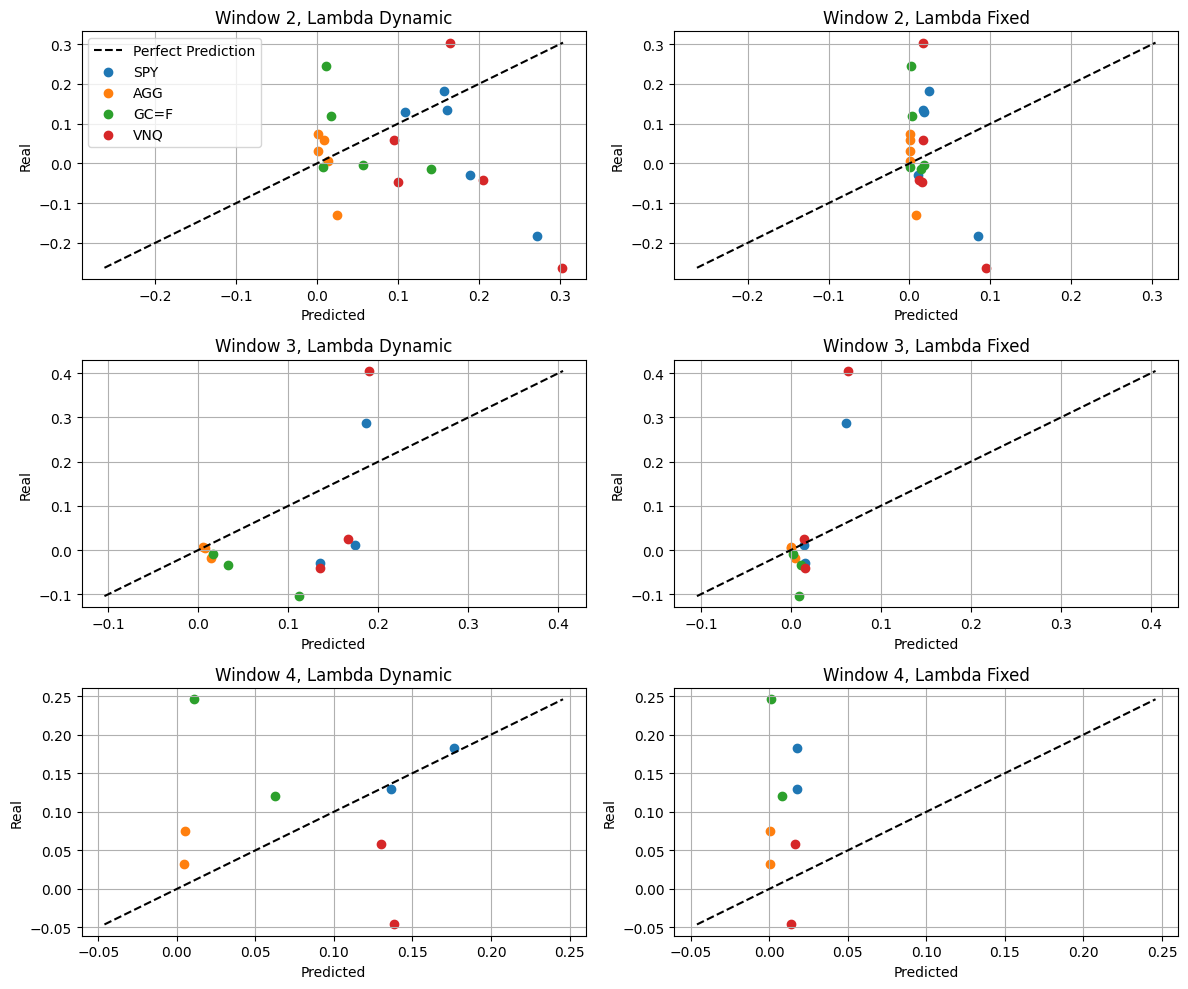

In [78]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.ravel()
index = 0

for i in range(2, 5):
    for j in [True, False]:
        result = switch(i, j)
        comparison_clean = result.dropna(subset=['Real', 'Predicted'])
        ax = axes[index]

        ax_min = min(comparison_clean['Predicted'].min(), comparison_clean['Real'].min())
        ax_max = max(comparison_clean['Predicted'].max(), comparison_clean['Real'].max())
        ax.plot([ax_min, ax_max], [ax_min, ax_max], 'k--', label='Perfect Prediction')

        for ticker in tickers:
            data = comparison_clean[comparison_clean['Ticker'] == ticker]
            ax.scatter(data['Predicted'], data['Real'], label=ticker)

        ax.set_xlabel('Predicted')
        ax.set_ylabel('Real')
        title_lambda = "Dynamic" if j else "Fixed"
        ax.set_title(f'Window {i}, Lambda {title_lambda}')
        
        if index == 0:
            ax.legend()

        ax.grid(True)
        index += 1

plt.tight_layout()
plt.show()
